# APS 2 - NLP

### Feito por:
- Henrique Martinelli Frezzatti

### Banco de dados utilizado: 
O banco de dados utilizado para essa APS é o mesmo utilizado na APS 1 e foi criado utilizando a API do Art Institute of Chicago.

Importação de bibliotecas e criação de uma função de limpeza de texto para melhor treinamento do modelo.

In [25]:
import torch
import torch.nn as nn
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import re
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def clean_text(text):
    # Remove tags HTML
    text = re.sub(r'<[^>]*>', '', text)
    # Remove múltiplos espaços e quebra de linha
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove caracteres não desejados
    text = re.sub(r'[^\w\s.,!?\'\"-]', '', text)
    return text

Carregando o dataset, limpando-o e visualizando-o.

In [8]:
# Carregar o dataset
data = pd.read_csv("art-db.csv")

# Concatenar campos textuais
data['text'] = data['title'].fillna('') + " " + data['artist_title'].fillna('') + " " + data['description'].fillna('')

# Aplicar limpeza no texto concatenado
data['text'] = data['text'].apply(clean_text)

# Visualizar os primeiros registros após a limpeza
data.head()

,id,title,artist_title,description,publication_history,medium_display,date_display,text
0,184102,Weights and Measures,Richard Serra,"<p>Capturing the raw, muscular energy required...",NaN,Hot-rolled steel,1987,Weights and Measures Richard Serra Capturing t...
1,157156,Red Yellow Blue White and Black II,Ellsworth Kelly,<p><em>Red Yellow Blue White and Black II</em>...,NaN,Oil on canvas; 7 joined panels,1953,Red Yellow Blue White and Black II Ellsworth K...
2,80084,The Crucifixion,Francisco de Zurbarán,"<p>Beginning in the mid-sixteenth century, the...","Antonio Palomino de Castro y Velasco, El Museo...",Oil on canvas,1627,The Crucifixion Francisco de Zurbarán Beginnin...
3,73417,The Beginning,Barnett Newman,<p>A key figure in the Abstract Expressionist ...,"Harold Rosenberg, ""Barnett Newman: A Man of Co...",Oil on canvas,1946,The Beginning Barnett Newman A key figure in t...
4,19336,The Resurrection,Cecco del Caravaggio,<p>Francesco Buoneri was one of the closest fo...,"Mahonri Sharp Young, ""Letter from U.S.A.: The ...",Oil on canvas,c. 1619-20,The Resurrection Cecco del Caravaggio Francesc...


Carregando modelo e gerando embeddings

In [9]:
# Carregar modelo sBERT
model = SentenceTransformer('all-MiniLM-L6-v2')

# Gerar embeddings
embeddings = model.encode(data['text'].tolist(), convert_to_tensor=True)

Separando dados para treino

In [10]:
# Separar dados para treino e validação
train_embeddings, val_embeddings = train_test_split(embeddings, test_size=0.2, random_state=42)

# Configurar DataLoader para PyTorch
train_data = TensorDataset(train_embeddings)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [11]:
# Autoencoder para ajuste dos embeddings
class EmbeddingAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim=128):
        super(EmbeddingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 256),
            nn.ReLU(),
            nn.Linear(256, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Realizando treinamento

In [12]:
# Inicializar modelo, função de perda e otimizador
input_dim = embeddings.shape[1]
autoencoder = EmbeddingAutoencoder(input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)

# Treinamento do autoencoder
epochs = 10
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        inputs = batch[0]
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

Epoch [1/10], Loss: 0.0010
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0006
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


In [14]:
# Salvar o modelo ajustado e embeddings otimizados
torch.save(autoencoder.state_dict(), 'embedding_autoencoder.pth')
optimized_embeddings = autoencoder.encoder(embeddings).detach().numpy()

In [56]:
# Projeção com t-SNE dos embeddings originais (pré-treinados)
tsne_original = TSNE(n_components=2, random_state=42, perplexity=40)
original_2d = tsne_original.fit_transform(embeddings.cpu().numpy())

# Projeção com t-SNE dos embeddings otimizados
tsne_optimized = TSNE(n_components=2, random_state=42, perplexity=40)
optimized_2d = tsne_optimized.fit_transform(optimized_embeddings)

Visualização

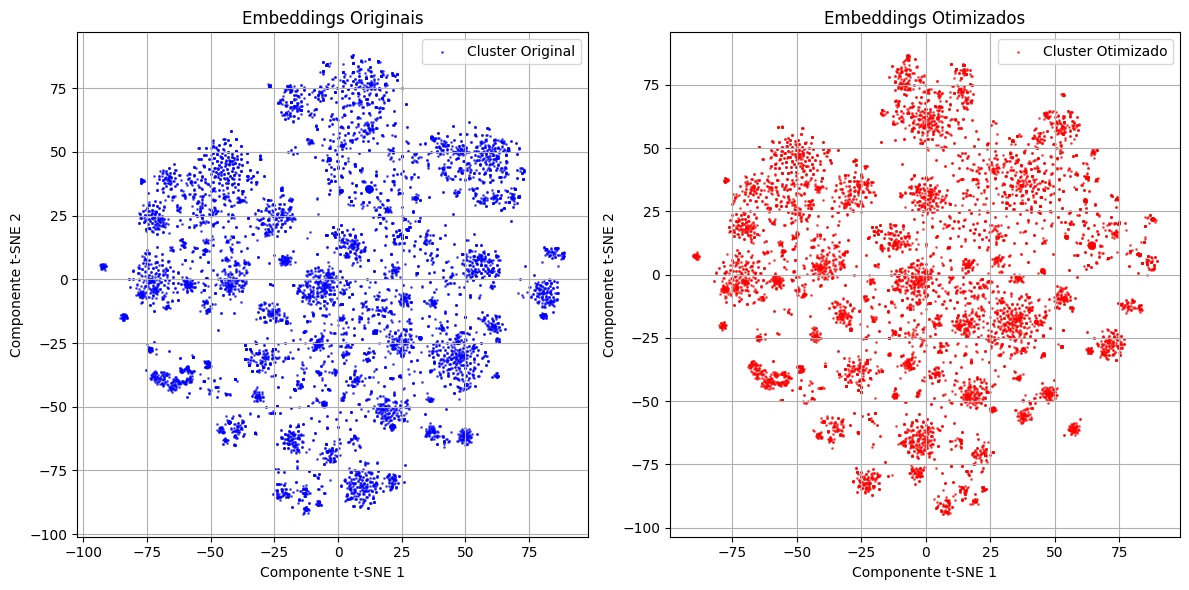

In [57]:
# Visualização e salvamento dos embeddings
plt.figure(figsize=(12, 6))

# Embeddings Originais
plt.subplot(1, 2, 1)
plt.scatter(original_2d[:, 0], original_2d[:, 1], s=1, alpha=0.6, c='blue', label='Cluster Original')
plt.title("Embeddings Originais")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend()
plt.grid(True)
plt.savefig("embeddings_originais_detalhados.png")

# Embeddings Otimizados
plt.subplot(1, 2, 2)
plt.scatter(optimized_2d[:, 0], optimized_2d[:, 1], s=1, alpha=0.6, c='red', label='Cluster Otimizado')
plt.title("Embeddings Otimizados")
plt.xlabel("Componente t-SNE 1")
plt.ylabel("Componente t-SNE 2")
plt.legend()
plt.grid(True)
plt.savefig("embeddings_otimizados_detalhados.png")

plt.tight_layout()
plt.show()

Criando funções para execução das queries e, assim, testar o modelo

In [49]:
# Função para gerar embedding reduzido de uma consulta
def embed_query(query):
    query_embedding = model.encode([query], convert_to_tensor=True).detach()
    query_embedding_reduced = autoencoder.encoder(query_embedding).detach().numpy()
    return query_embedding_reduced

# Função para executar a busca no conjunto de dados, com limite de similaridade
def search(query, top_k=10, min_similarity=0.6):
    query_embedding_reduced = embed_query(query)
    
    # Calcular similaridade entre a consulta e todos os embeddings otimizados
    similarities = cosine_similarity(query_embedding_reduced, optimized_embeddings)[0]
    
    # Filtrar resultados com similaridade acima do limite especificado
    filtered_indices = [i for i, sim in enumerate(similarities) if sim >= min_similarity]
    filtered_similarities = [similarities[i] for i in filtered_indices]
    
    # Ordenar os resultados filtrados por similaridade
    sorted_indices = sorted(range(len(filtered_similarities)), key=lambda i: filtered_similarities[i], reverse=True)
    final_indices = [filtered_indices[i] for i in sorted_indices]
    
    # Evitar duplicados
    seen_texts = set()
    unique_texts = []
    unique_similarities = []
    
    for idx in final_indices:
        text = data.iloc[idx]['text']
        if text not in seen_texts:
            seen_texts.add(text)
            unique_texts.append(text)
            unique_similarities.append(similarities[idx])
            if len(unique_texts) >= top_k:
                break
    
    # Retornar os textos e similaridades dos resultados finais
    return unique_texts, unique_similarities

In [53]:
# Definir consultas para os três tipos de teste
queries = [
    "surrealism",  # Espera-se que retorne menos de 10 resultados 
    "impressionism",  # Espera-se que retorne 10 resultados
    "cross"  # Busca não óbvia, esperando mensagens semelhantes
]

# Executar cada consulta e mostrar os resultados
for i, query in enumerate(queries):
    print(f"\nTeste {i+1}: Consulta - '{query}'")
    results, scores = search(query)
    for j, (text, score) in enumerate(zip(results, scores)):
        print(f"Resultado {j+1}:")
        print(f"Texto: {text}")
        print(f"Similaridade: {score:.4f}")
        print("-" * 50)


Teste 1: Consulta - 'surrealism'
Resultado 1:
Texto: The Kerosene Lamp Joan Miró The Spanish artist Joan Miró was one of the leading exponents of Surrealism. His drawing The Kerosene Lamp has often been interpreted as autobiographicala view of the artist's studiobut the elements of his work are intended to be suggestive rather than specific in meaning.
Similaridade: 0.6589
--------------------------------------------------
Resultado 2:
Texto: Untitled Yves Tanguy The largely self-taught Yves Tanguy decided to become an artist around 1923, when he was inspired by a painting by Giorgio de Chirico that he saw in a shop window. Tanguy became interested in Surrealism a year later, after reading the periodical La révolution surréaliste. André Breton welcomed him into the Surrealist group in 1925. Inspired by the metaphysical qualities of de Chiricos work, as well as the biomorphic forms of Jean Arp, Max Ernst, and Joan Miró, Tanguy quickly developed his own fantastic vocabulary of organic, 